# 1. Prepare the environment

In [142]:
# List all NVIDIA GPUs as avaialble in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-9ddd7394-07dd-4f5b-d7b2-16595b853298)


In [143]:
import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]

NumPy 1.21.6

TensorFlow 2.9.2
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [144]:
# Set fixed seeding values for reproducability during experiments
# Skip this cell if random initialization (with varied results) is needed
#np.random.seed(1234)
#tf.random.set_seed(5678)

# 2. Load the pretrained model (only the feature extractor)

In [145]:
# Load the ImageNet EfficientNetB0 model, ***excluding*** the latter part regarding the classifier
# Default of input_shape is 224x224x3 for EfficientNetB0
img_w,img_h = 224,224     # image size of CIFAR-10
eff_extractor = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(img_w, img_h, 3)
)
eff_extractor.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_10 (Rescaling)       (None, 224, 224, 3)  0           ['input_11[0][0]']               
                                                                                                  
 normalization_10 (Normalizatio  (None, 224, 224, 3)  7          ['rescaling_10[0][0]']           
 n)                                                                                               
                                                                                     

# 3. Prepare our dataset

In [146]:
import pickle
# Load CIFAR-10 color image dataset
file = open('/content/data_set2.plk', 'rb')
data_all = pickle.load(file)
x,y=data_all
A=int(len(x)*0.8)
x_train , y_train = x[0:A],y[0:A]
x_test , y_test =x[A::],y[A::]

x_train=np.array(x_train)
x_test=np.array(x_test)

y_train=np.array(y_train)
y_test=np.array(y_test)

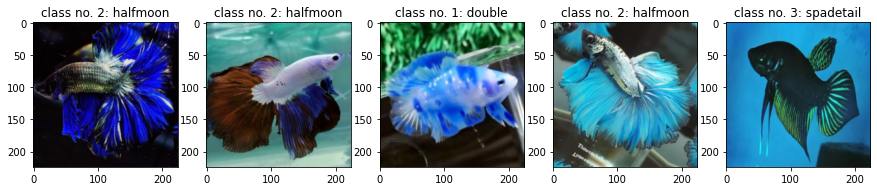

In [147]:
cifar4_labels = ['crowntail', 'double', 'halfmoon', 'spadetail']
# Visualize the first five images in x_train
plt.figure(figsize=(15,5))
for i in range(0,5):
    plt.subplot(150 + 1 + i).set_title( f"class no. {y_train[i]}: {cifar4_labels[ int(y_train[i]) ]}" )                
    plt.imshow( x_train[i] )
    #plt.axis( "off" )        
plt.show()

In [148]:
# Preprocess CIFAR-10 dataset to match efficientnet's requirements
x_train_eff = tf.keras.applications.efficientnet.preprocess_input(x_train)
x_test_eff = tf.keras.applications.efficientnet.preprocess_input(x_test)

print( x_train_eff.dtype, x_train_eff.shape, np.min(x_train_eff), np.max(x_train_eff) )
print( x_test_eff.dtype, x_test_eff.shape, np.min(x_test_eff), np.max(x_test_eff) )

uint8 (779, 224, 224, 3) 0 255
uint8 (195, 224, 224, 3) 0 255


# 4. Prepare for transfer learning and finetuning

- Add the new classification head
- Decide whether to freeze or unfreeze any pretrained layers

## 4.1 Access and freeze layer(s) in Keras's model

In [149]:
# Recursively freeze all layers in the model
eff_extractor.trainable = False

for i,layer in enumerate(eff_extractor.layers):  
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )


Layer 0: name = input_11 , trainable = False
Layer 1: name = rescaling_10 , trainable = False
Layer 2: name = normalization_10 , trainable = False
Layer 3: name = tf.math.truediv_10 , trainable = False
Layer 4: name = stem_conv_pad , trainable = False
Layer 5: name = stem_conv , trainable = False
Layer 6: name = stem_bn , trainable = False
Layer 7: name = stem_activation , trainable = False
Layer 8: name = block1a_dwconv , trainable = False
Layer 9: name = block1a_bn , trainable = False
Layer 10: name = block1a_activation , trainable = False
Layer 11: name = block1a_se_squeeze , trainable = False
Layer 12: name = block1a_se_reshape , trainable = False
Layer 13: name = block1a_se_reduce , trainable = False
Layer 14: name = block1a_se_expand , trainable = False
Layer 15: name = block1a_se_excite , trainable = False
Layer 16: name = block1a_project_conv , trainable = False
Layer 17: name = block1a_project_bn , trainable = False
Layer 18: name = block2a_expand_conv , trainable = False
Laye

'\n\ne = eff_extractor.get_layer(\'block7a_project_conv\') \ne.trainable = True \nprint( f"Layer {c}: name = {c.name} , trainable = {c.trainable}" )\n\n\nf = eff_extractor.get_layer(\'block7a_se_excite\') \nf.trainable = True \nprint( f"Layer {c}: name = {c.name} , trainable = {c.trainable}" )\n\n \ng = eff_extractor.get_layer(\'block7a_se_excite\') \ng.trainable = True \nprint( f"Layer {c}: name = {c.name} , trainable = {c.trainable}" )\n'

In [150]:
# Iterate over all layers in the model
for i,layer in enumerate(eff_extractor.layers):  
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_11 , trainable = False
Layer 1: name = rescaling_10 , trainable = False
Layer 2: name = normalization_10 , trainable = False
Layer 3: name = tf.math.truediv_10 , trainable = False
Layer 4: name = stem_conv_pad , trainable = False
Layer 5: name = stem_conv , trainable = False
Layer 6: name = stem_bn , trainable = False
Layer 7: name = stem_activation , trainable = False
Layer 8: name = block1a_dwconv , trainable = False
Layer 9: name = block1a_bn , trainable = False
Layer 10: name = block1a_activation , trainable = False
Layer 11: name = block1a_se_squeeze , trainable = False
Layer 12: name = block1a_se_reshape , trainable = False
Layer 13: name = block1a_se_reduce , trainable = False
Layer 14: name = block1a_se_expand , trainable = False
Layer 15: name = block1a_se_excite , trainable = False
Layer 16: name = block1a_project_conv , trainable = False
Layer 17: name = block1a_project_bn , trainable = False
Layer 18: name = block2a_expand_conv , trainable = False
Laye

## 4.2 Add a new classification head

In [151]:
x = eff_extractor.output

# Add our custom layer(s) to the end of the existing model 
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x)

# Construct the main model 
model = tf.keras.models.Model(inputs=eff_extractor.inputs, outputs=new_outputs)
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_10 (Rescaling)       (None, 224, 224, 3)  0           ['input_11[0][0]']               
                                                                                                  
 normalization_10 (Normalizatio  (None, 224, 224, 3)  7          ['rescaling_10[0][0]']           
 n)                                                                                               
                                                                                            

# 5. Train the model with transfer learning

No finetuning is done in this example as all pretrained layers are freezed and only newly added layers are trained.

In [152]:
model.compile( loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"] ) 

In [153]:
import time
start_time = time.time()
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="/content/best_weights.hdf5",  monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(x_train_eff, y_train, callbacks=[callbacks_list], batch_size=15, verbose=1, epochs=100, validation_split = 0.2)
print("--- %s seconds ---" % (round(time.time() - start_time,2)))

Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 3.5262 - acc: 0.7833
Epoch 1: val_acc improved from -inf to 0.92308, saving model to /content/best_weights.hdf5
42/42 [==============================] - 12s 126ms/step - loss: 3.5262 - acc: 0.7833 - val_loss: 1.9821 - val_acc: 0.9231
Epoch 2/100
41/42 [============================>.] - ETA: 0s - loss: 0.6161 - acc: 0.9512
Epoch 2: val_acc improved from 0.92308 to 0.94231, saving model to /content/best_weights.hdf5
42/42 [==============================] - 4s 101ms/step - loss: 0.6082 - acc: 0.9518 - val_loss: 1.8683 - val_acc: 0.9423
Epoch 3/100
41/42 [============================>.] - ETA: 0s - loss: 0.5489 - acc: 0.9675
Epoch 3: val_acc did not improve from 0.94231
42/42 [==============================] - 2s 49ms/step - loss: 0.5418 - acc: 0.9679 - val_loss: 2.3701 - val_acc: 0.9295
Epoch 4/100
41/42 [============================>.] - ETA: 0s - loss: 0.5326 - acc: 0.9756
Epoch 4: val_acc improved from 0.94231 to 0.97

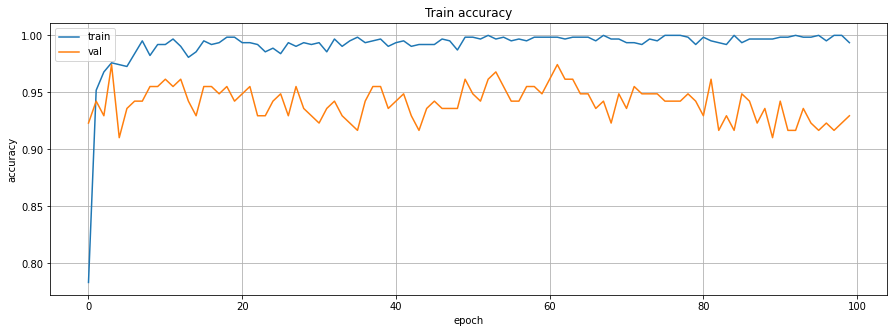

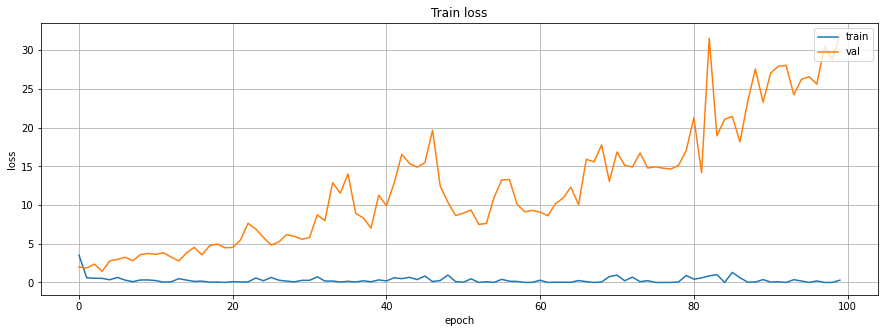

In [154]:
# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

# 6. Evaluate the model on test set

In [155]:
# Evaluate the trained model on the test set
model.load_weights('/content/best_weights.hdf5')
results = model.evaluate(x_test_eff, y_test, batch_size=20)
print( f"{model.metrics_names}: {results}" )


len(y_test)

10/10 [==============================] - 0s 46ms/step - loss: 2.3658 - acc: 0.9282
['loss', 'acc']: [2.365779161453247, 0.928205132484436]


195

# 7. Inference

1/1 [==============================] - 0s 24ms/step


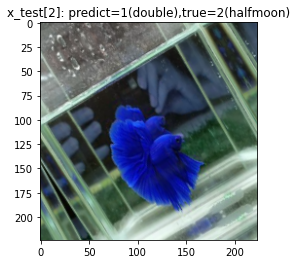

1/1 [==============================] - 0s 23ms/step


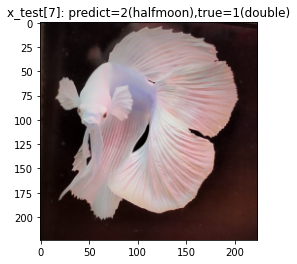

1/1 [==============================] - 0s 25ms/step


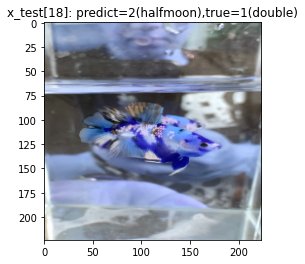

1/1 [==============================] - 0s 22ms/step


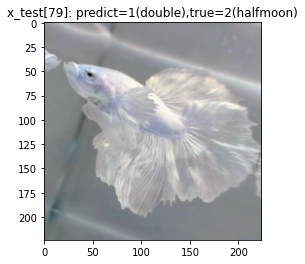

1/1 [==============================] - 0s 25ms/step


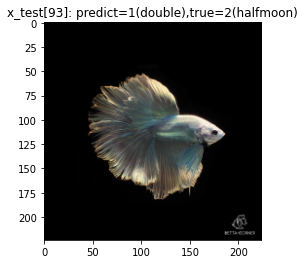

1/1 [==============================] - 0s 26ms/step


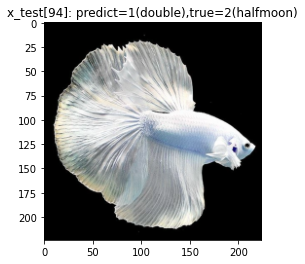

1/1 [==============================] - 0s 26ms/step


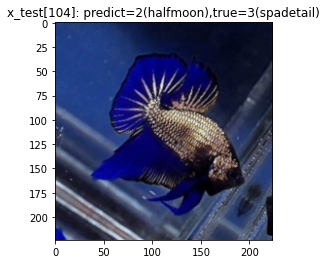

1/1 [==============================] - 0s 25ms/step


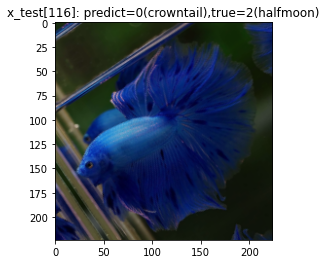

1/1 [==============================] - 0s 25ms/step


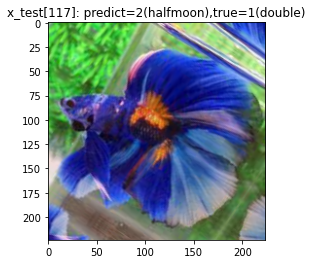

1/1 [==============================] - 0s 24ms/step


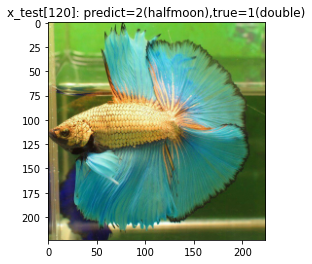

1/1 [==============================] - 0s 23ms/step


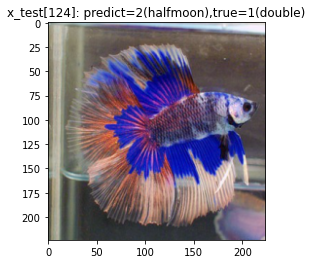

1/1 [==============================] - 0s 26ms/step


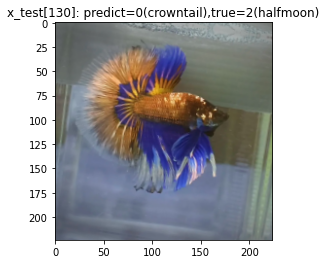

1/1 [==============================] - 0s 26ms/step


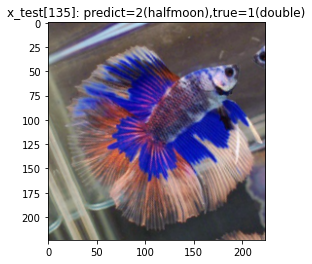

1/1 [==============================] - 0s 26ms/step


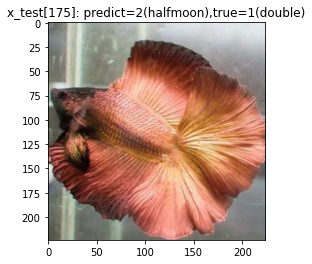

1/1 [==============================] - 0s 26ms/step


In [156]:
# Test using the model on the first 20 images in x_test
for i in range(len(y_test)-1):
    y_pred = model.predict(x_test[i].reshape(1,224,224,3))
    y_pred2=np.argmax(y_pred)
    if y_pred2  != y_test[i]:
        plt.imshow(x_test[i] )
        plt.title(f"x_test[{i}]: predict={np.argmax(y_pred)}({cifar4_labels[np.argmax(y_pred)]}),true={y_test[i]}({cifar4_labels[int(y_test[i])]})" )
        plt.show()